In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Dict, Any, Set
from fd_analysis.prepare import filter_corrupt_files, get_python_projects, get_code_dirs,get_depsfiles, reduce_directory_levels
from fd_analysis.explore import codedirs_per_filetype, get_dependencies_declaration

## Import data

In [2]:
# import Biomedical's data
paths_biomed = "../data/results_biomed_20240423"
raw_data_biomed, corrupt_biomed = filter_corrupt_files([Path(paths_biomed) / file for file in os.listdir(paths_biomed)])
if not corrupt_biomed:
    print("Biomedical data OK")
else:
    print(f"Corrupt data ({len(corrupt_biomed)}) projects: ", corrupt_biomed)

# import PyPi data
paths_pypi = "../data/results_pypi_20240423"
raw_data_pypi, corrupt_pypi = filter_corrupt_files([Path(paths_pypi) / file for file in os.listdir(paths_pypi)])
if not corrupt_pypi:
    print("PyPi data OK")
else:
    print(f"Corrupt data ({len(corrupt_pypi)}) projects: ", corrupt_pypi)

Biomedical data OK
PyPi data OK


## Filter data: include Python projects only

In [3]:
python_projects_biomed = get_python_projects(raw_data_biomed) 
data_biomed = {k:v for k, v in raw_data_biomed.items() if v["metadata"]["project_name"] in python_projects_biomed}
print(f"Number of biomedical Python projects {len(python_projects_biomed)} out of {len(raw_data_biomed)} total.")

python_projects_pypi = get_python_projects(raw_data_pypi)
data_pypi = {k:v for k, v in raw_data_pypi.items() if v["metadata"]["project_name"] in python_projects_pypi}
print(f"Number of PyPi Python projects {len(python_projects_pypi)} out of {len(raw_data_pypi)} total.")

Number of biomedical Python projects 1260 out of 1818 total.
Number of PyPi Python projects 1118 out of 1160 total.


In [4]:
#  Get projects from PyPi that are not markes as Python projects

# Note: some of them are archived, some of them do not require external dependencies
{v["metadata"]["repo_url"] for k,v in data_pypi.items() if v["metadata"]["project_name"] not in python_projects_pypi}

set()

## Format data

In [5]:
pypi_codedirs_df = get_code_dirs(data_pypi)
biomed_codedirs_df = get_code_dirs(data_biomed)


pypi_only_py_df, pypi_only_ipynb_df = codedirs_per_filetype(pypi_codedirs_df)
biomed_only_py_df, biomed_only_ipynb_df = codedirs_per_filetype(biomed_codedirs_df)

# dependency files
biomed_deps = get_depsfiles(data_biomed)
pypi_deps = get_depsfiles(data_pypi)

732
1117


## Project types

### Baseline - all projects

In [6]:

def get_all_projects(codedirs_py, codedirs_ipynb, data_python, show_stats=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''
    
    matched_projects = (codedirs_py + codedirs_ipynb).dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_soup_projects = len(matched_projects)
    n_projects = len(data_python)
    print(f"Number of  projects: {n_soup_projects} out of {n_projects} total, {round(len(matched_projects) / n_projects * 100, 2)} %")
    # display(matched_projects.head(10))
    deps_declaration_soup = [len(get_dependencies_declaration(v["deps_file"]))>0 
                                for v in data_python.values()
                            if v["metadata"]["project_name"] in set(matched_projects.index)]
    print(f"Percent of projects that have declaration: {round(sum(deps_declaration_soup) / len(matched_projects) * 100, 2)} %")
    if show_stats and n_soup_projects > 0 :
        matched_projects.sum(axis=1).hist(bins=100, figsize=(12, 6))
        plt.title("Number of projects with a given number of Python files and notebooks in the main directory")
        plt.show()
    return matched_projects, sum(deps_declaration_soup)

Number of  projects: 1118 out of 1118 total, 100.0 %
Percent of projects that have declaration: 83.36 %


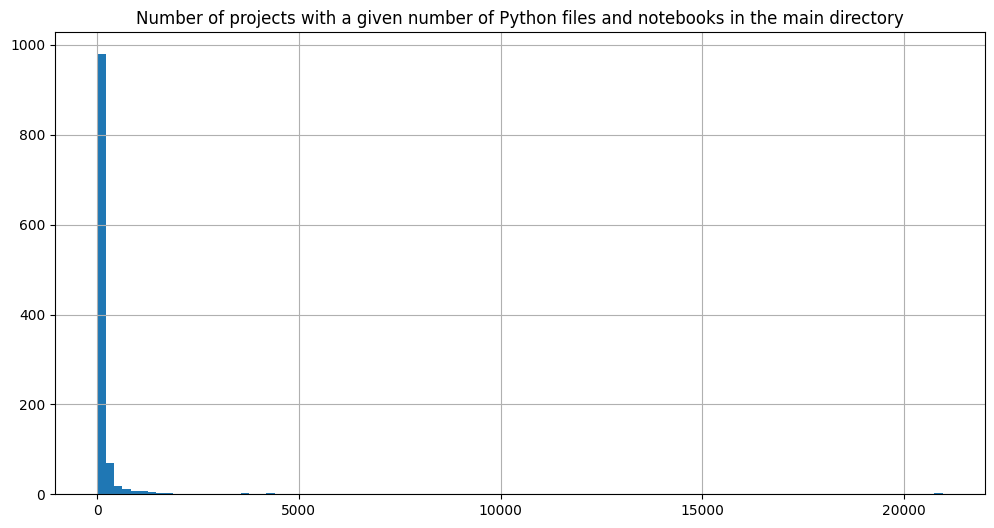

In [7]:
pypi_all_projects, _ = get_all_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi)

Number of  projects: 1260 out of 1260 total, 100.0 %
Percent of projects that have declaration: 50.63 %


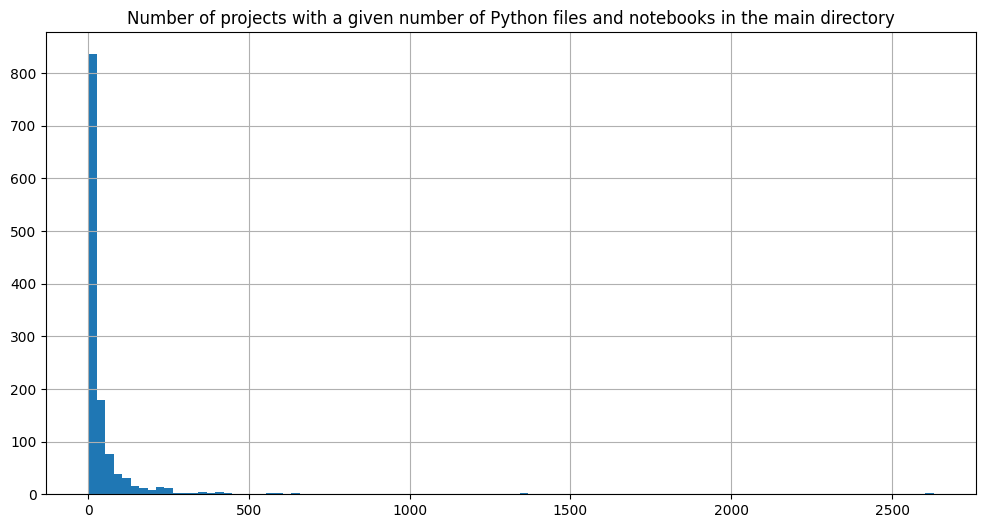

In [8]:
biomed_all_projects, _ = get_all_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)

### Soup projects

In [9]:
# identify project type 
def get_soup_projects(codedirs_py, codedirs_ipynb, data_python, show_stats=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    cond = (
        ((codedirs_ipynb['.'] > 0) | (codedirs_py['.'] > 0)) & 
        (codedirs_py.drop('.', axis=1).sum(axis=1) == 0) & 
        (codedirs_ipynb.drop('.', axis=1).sum(axis=1) == 0))
    
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_soup_projects = len(matched_projects)
    n_projects = len(data_python)
    print(f"Number of soup projects: {n_soup_projects} out of {n_projects} total, {round(len(matched_projects) / n_projects * 100, 2)} %")
    # display(matched_projects.head(10))
    deps_declaration_soup = [len(get_dependencies_declaration(v["deps_file"]))>0 
                                for v in data_python.values()
                            if v["metadata"]["project_name"] in set(matched_projects.index)]
    print(f"Percent of soup projects that have declaration: {round(sum(deps_declaration_soup) / len(matched_projects) * 100, 2)} %")
    if show_stats and n_soup_projects > 0 :
        matched_projects.hist(bins=100, figsize=(12, 6))
        plt.title("Number of projects with a given number of Python files and notebooks in the main directory")
        plt.show()
    return matched_projects, sum(deps_declaration_soup)


Number of soup projects: 29 out of 1118 total, 2.59 %
Percent of soup projects that have declaration: 55.17 %


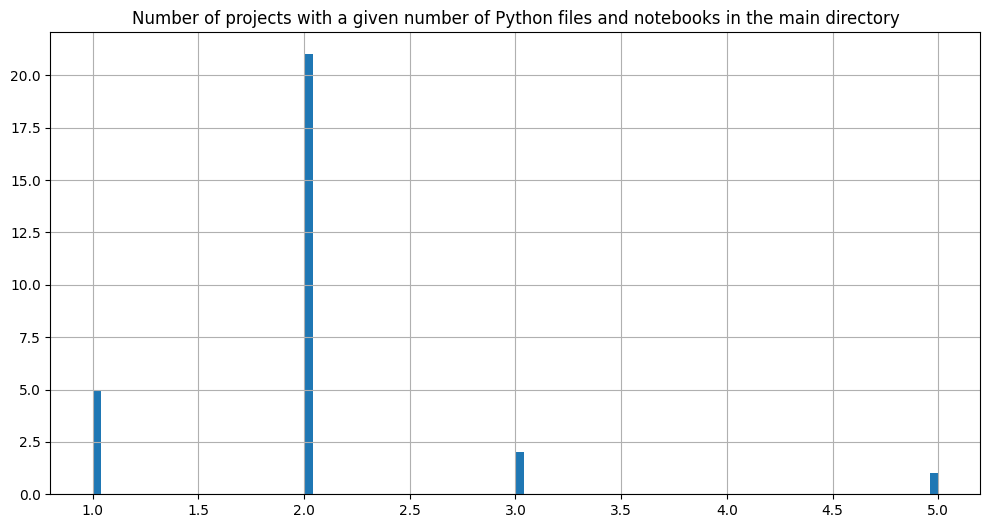

In [10]:
pypi_soup_projects, _ = get_soup_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi)

Number of soup projects: 205 out of 1260 total, 16.27 %
Percent of soup projects that have declaration: 18.05 %


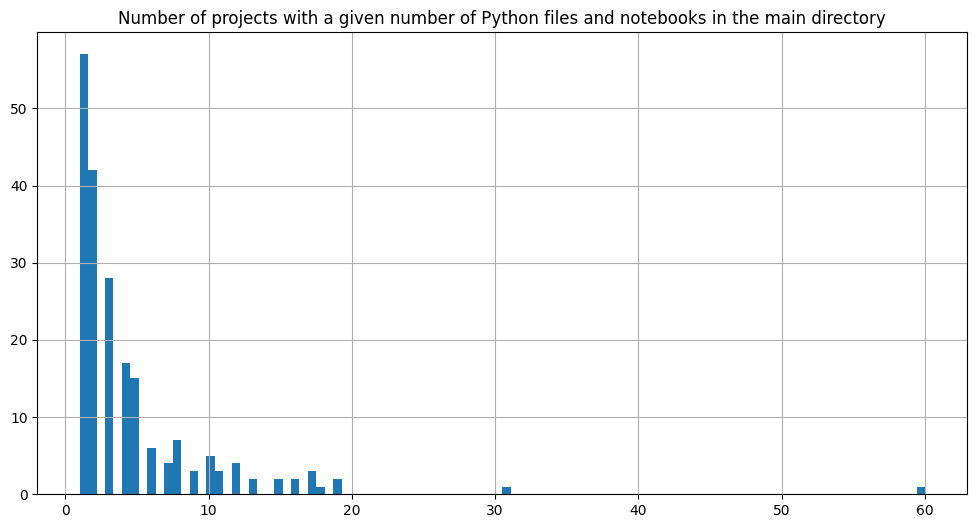

In [11]:
biomed_soup_projects, _ = get_soup_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)

### SRC project

In [12]:
# identify project type 
def get_src_projects(codedirs_py, codedirs_ipynb, data_python, show_stats=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    ipynb_columns = [col for col in codedirs_ipynb.columns if 'src' in col]
    py_columns = [col for col in codedirs_py.columns if 'src' in col]
    cond = ((codedirs_ipynb[ipynb_columns].sum(axis=1) > 0) | 
            (codedirs_py[py_columns].sum(axis=1) > 0))
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_matched_projects = len(matched_projects)
    n_projects = len(data_python)
    print(f"Number of src projects: {n_matched_projects} out of {n_projects} total, {round(len(matched_projects) / n_projects * 100, 2)} %")
    # display(matched_projects.head(10))
    deps_declaration_soup = [len(get_dependencies_declaration(v["deps_file"]))>0 
                                for v in data_python.values()
                            if v["metadata"]["project_name"] in set(matched_projects.index)]
    print(f"Percent of same-name projects that have declaration: {round(sum(deps_declaration_soup) / len(matched_projects) * 100, 2)} %")
    if show_stats and n_matched_projects > 0 :
        matched_projects.sum(axis=1).hist(bins=100, figsize=(12, 6))
        plt.title("Number of projects with a given number of Python files and notebooks total")
        plt.show()
    return matched_projects, sum(deps_declaration_soup)


Number of src projects: 220 out of 1118 total, 19.68 %
Percent of same-name projects that have declaration: 88.64 %


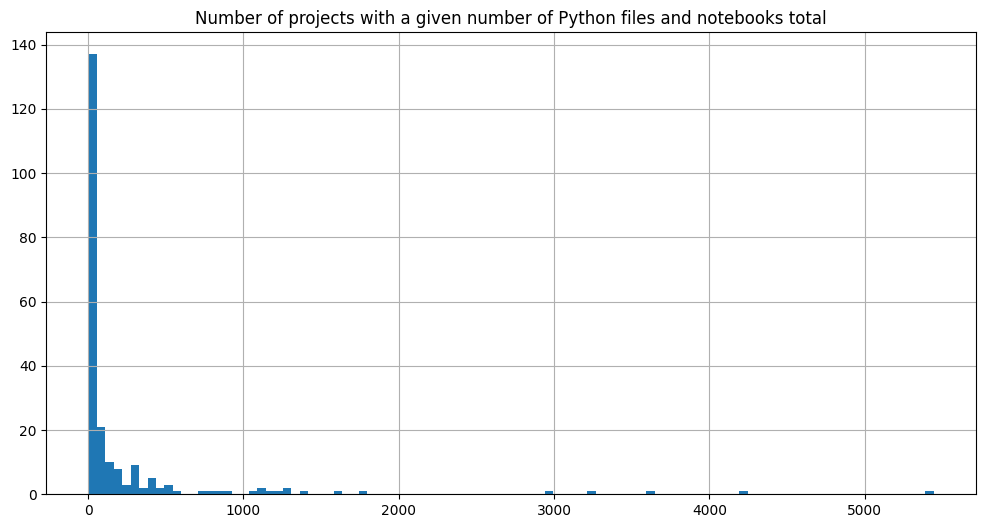

In [13]:
pypi_src_projects, _ = get_src_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi)

Number of src projects: 134 out of 1260 total, 10.63 %
Percent of same-name projects that have declaration: 64.93 %


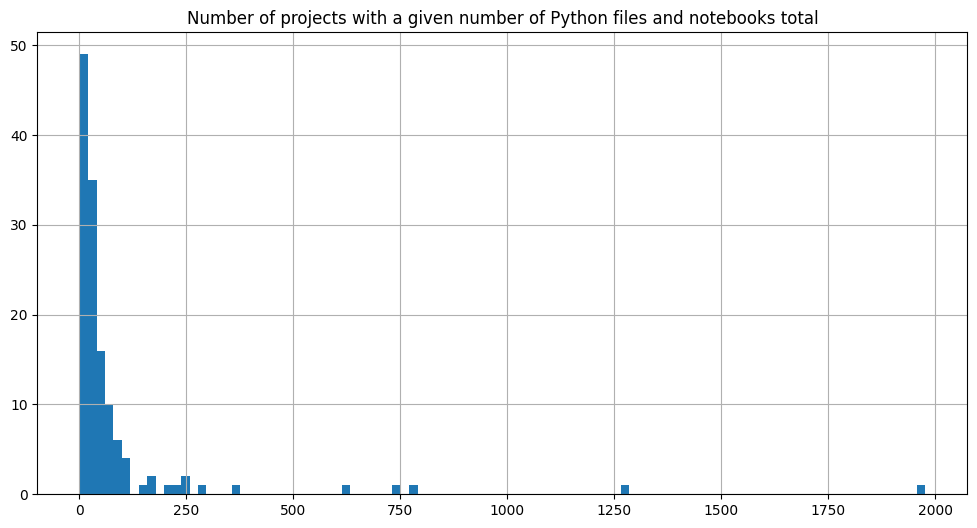

In [14]:
biomed_src_projects, _ = get_src_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)

### Project with the same name

In [15]:
# identify project type 
def get_same_name_projects(codedirs_py, codedirs_ipynb, data_python, show_stats=True):
    '''
    Define and analyse
    "soup" projects - having all the code in the main project directory'''

    ipynb_columns = [col for col in codedirs_ipynb.columns if 'PROJECT_NAME' in col]
    py_columns = [col for col in codedirs_py.columns if 'PROJECT_NAME' in col]
    cond = ((codedirs_ipynb[ipynb_columns].sum(axis=1) > 0) | 
            (codedirs_py[py_columns].sum(axis=1) > 0))
    matched_projects = (codedirs_py + codedirs_ipynb)[cond].dropna(axis=1, how='all').sort_values(by='.', ascending=False)
    n_matched_projects = len(matched_projects)
    n_projects = len(data_python)
    print(f"Number of same-name projects: {n_matched_projects} out of {n_projects} total, {round(len(matched_projects) / n_projects * 100, 2)} %")
    # display(matched_projects.head(10))
    deps_declaration_soup = [len(get_dependencies_declaration(v["deps_file"]))>0 
                                for v in data_python.values()
                            if v["metadata"]["project_name"] in set(matched_projects.index)]
    print(f"Percent of same-name projects that have declaration: {round(sum(deps_declaration_soup) / len(matched_projects) * 100, 2)} %")
    if show_stats and n_matched_projects > 0 :
        matched_projects.sum(axis=1).hist(bins=100, figsize=(12, 6))
        plt.title("Number of projects with a given number of Python files and notebooks total")
        plt.show()

    return matched_projects, sum(deps_declaration_soup)


Number of same-name projects: 434 out of 1118 total, 38.82 %
Percent of same-name projects that have declaration: 82.95 %


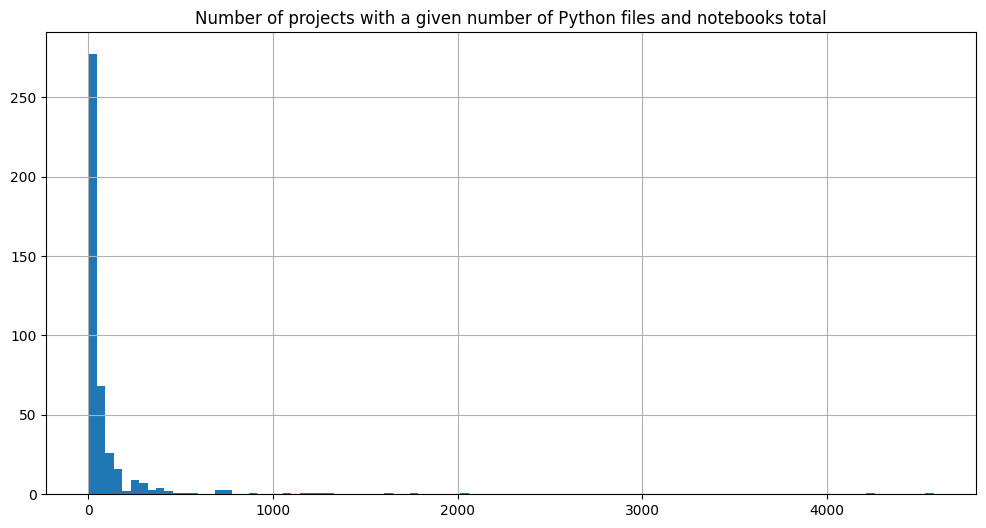

In [16]:
pypi_same_name_projects, _ = get_same_name_projects(pypi_only_py_df, pypi_only_ipynb_df, data_python=data_pypi)    

Number of same-name projects: 342 out of 1260 total, 27.14 %
Percent of same-name projects that have declaration: 83.33 %


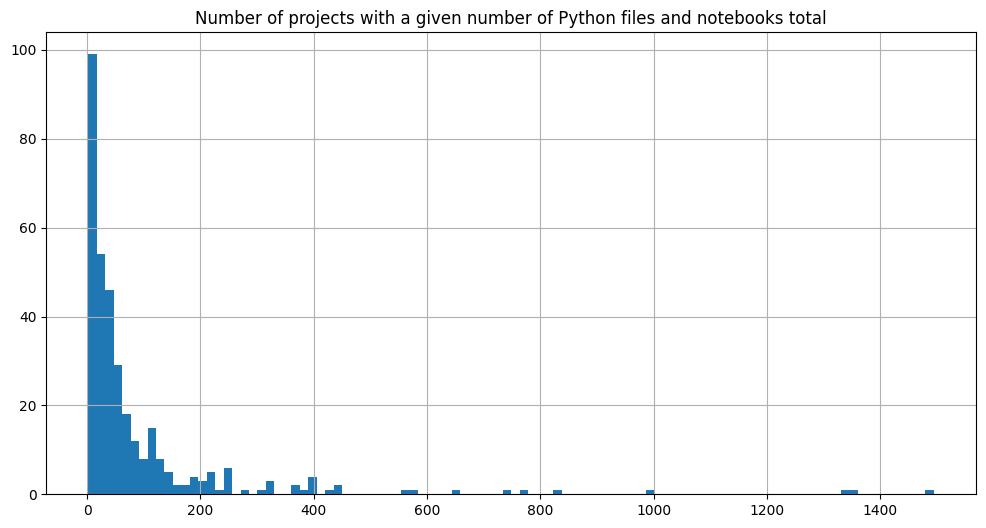

In [17]:

biomed_same_name_projects, _ = get_same_name_projects(biomed_only_py_df, biomed_only_ipynb_df, data_python=data_biomed)